<a href="https://colab.research.google.com/github/lwgmiller/HonoursProject-reharmonisationGAN/blob/main/ReharmonisationGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
!apt-get install python3.5

print(python_version())

In [1]:

!pip3 install torch matplotlib tqdm livelossplot gdown "pypianoroll>=1.0.2"

#!pip3 install py_midi
#import midi

In [2]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os, os.path, shutil
import zipfile
import random
import json
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
import pretty_midi
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot



import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import moviepy.editor as mpy
import music21
from IPython import display
import seaborn as sns

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1687552/45929032 bytes (3.7%)4186112/45929032 bytes (9.1%)7331840/45929032 bytes (16.0%)10166272/45929032 bytes (22.1%)12623872/45929032 bytes (27.5%)13959168/45929032 bytes (30.4%)15482880/45929032 bytes (33.7%)17694720/45929032 bytes (38.5%)19996672/45929032 bytes (43.5%)22151168/45929032 bytes (48.2%)24330240/45929032 bytes (53.0%)26509312/45929032 bytes (57.7%)2

In [3]:
# Data
n_tracks = 5  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 100

# Training
batch_size = 16
latent_dim = 128
n_steps = 1000

# Sampling
sample_interval = 10  # interval to run the sampler (in step)
n_samples = 4

In [4]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'drive', 'sample_data']


In [ ]:
def show_pianoroll(xs, min_pitch=45, max_pitch=85,
                   programs = [0, 0, 0, 0], save_dir=None):
    """ Plot a MultiTrack PianoRoll
    :param x: Multi Instrument PianoRoll Tensor
    :param min_pitch: Min Pitch / Min Y across all instruments.
    :param max_pitch: Max Pitch / Max Y across all instruments.
    :param programs: Program Number of the Tracks.
    :param file_name: Optional. File Name to save the plot.
    :return:
    """

    # Convert fake_x to numpy and convert -1 to 0
    #xs = xs > 0

    channel_last = lambda x: np.moveaxis(np.array(x), 2, 0)
    xs = [channel_last(x) for x in xs]

    assert len(xs[0].shape) == 3, 'Pianoroll shape must have 3 dims, Got %d' % len(xs[0].shape)
    n_tracks, time_step, _ = xs[0].shape

    plt.ion()
    fig = plt.figure(figsize=(15, 4))
    
    x = xs[0]
    
    for j in range(4):
        b = j+1
        ax = fig.add_subplot(1,4,b)
        nz = np.nonzero(x[b-1])

        if programs:
            ax.set_xlabel('Time('+pretty_midi.program_to_instrument_class(programs[j%4])+')')

        if (j+1)== 1:
            ax.set_ylabel('Pitch')
        else:
            ax.set_yticks([])

        ax.scatter(nz[0], nz[1], s=np.pi * 3, color='bgrcmk'[b-1])
        ax.set_ylim(45, 85)
        ax.set_xlim(0, time_step)
        fig.add_subplot(ax)

In [5]:
from numpy.core.fromnumeric import shape
d = np.load("/content/drive/MyDrive/Colab Notebooks/Honours code/Jsb16thSeparated.npz", allow_pickle=True, encoding = 'latin1')

print(d.files)
train = d['train']
test = d['test']
valid = d['valid']

#print(valid[1])
track = test[0]

print(track.shape)
print(track)

#multitrack = pypianoroll.Multitrack(name='test1', resolution=24, tempo=np.ndarray(shape=(208,),dtype=np.float16), tracks=[Track(name='Soprano', program=0, is_drum=False, pianoroll=np.ndarray(shape=(208, 128), dtype=bool)), Track(name='Alto', program=0, is_drum=False, pianoroll=np.ndarray(shape=(208, 128), dtype=np.uint8)), Track(name='Tenor', program=0, is_drum=False, pianoroll=np.ndarray(shape=(208, 128), dtype=np.uint8)), Track(name='Bass', program=0, is_drum=False, pianoroll=np.ndarray(shape=(208, 128), dtype=bool))])

#print(multitrack)

#multitrack.plot()
#track = tf.convert_to_tensor(track)

#show_pianoroll(track)



['test', 'train', 'valid']
(228, 4)
[[65. 60. 57. 53.]
 [65. 60. 57. 53.]
 [65. 60. 57. 53.]
 [65. 60. 57. 53.]
 [72. 60. 55. 52.]
 [72. 60. 55. 52.]
 [70. 60. 55. 52.]
 [70. 60. 55. 52.]
 [69. 60. 53. 53.]
 [69. 60. 53. 53.]
 [67. 60. 55. 52.]
 [67. 60. 55. 52.]
 [65. 62. 57. 50.]
 [65. 62. 57. 50.]
 [65. 64. 58. 50.]
 [65. 64. 58. 50.]
 [72. 65. 60. 45.]
 [72. 65. 60. 45.]
 [72. 65. 60. 45.]
 [72. 65. 60. 45.]
 [74. 65. 60. 46.]
 [74. 65. 60. 46.]
 [74. 65. 58. 48.]
 [74. 65. 57. 48.]
 [74. 65. 58. 50.]
 [74. 65. 58. 50.]
 [74. 65. 58. 52.]
 [74. 65. 58. 52.]
 [72. 65. 57. 53.]
 [72. 65. 57. 53.]
 [72. 65. 57. 53.]
 [72. 65. 57. 53.]
 [72. 67. 60. 52.]
 [72. 67. 60. 52.]
 [72. 67. 60. 52.]
 [72. 67. 60. 52.]
 [74. 69. 60. 53.]
 [74. 69. 60. 53.]
 [74. 69. 60. 53.]
 [74. 69. 60. 53.]
 [76. 67. 59. 55.]
 [76. 67. 59. 55.]
 [76. 67. 59. 55.]
 [76. 67. 59. 55.]
 [77. 65. 60. 57.]
 [77. 65. 60. 57.]
 [77. 67. 62. 58.]
 [77. 67. 62. 58.]
 [76. 67. 64. 60.]
 [76. 67. 64. 60.]
 [76. 67. 55. 

In [ ]:

"""

length = multitrack.get_length()
print(length)
multitrack.trim(0, length)
multitrack.binarize()

multitrack.plot()


print(d.files)

for piece in d['valid']:
  
  valid.append(piece)

#print(valid)

for piece in d['train']:
  
  train.append(piece.shape)

print(train)

for piece in d['test']:
  
  test.append(piece.shape)

#print(test)



#print(piece.shape)

test1 = d['train']
print(test1.shape)

!mkdir -p data

src_file = Path("/content/drive/MyDrive/Colab Notebooks/Honours code/Jsb16thSeparated.npz")
dest_file = Path("/content/data/")
shutil.copy(src_file, dest_file)


#test1alto = pypianoroll.Track(name='Alto', program=0, is_drum=False, pianoroll=np.ndarray(shape=(208, 128), dtype=bool))
multitrack = pypianoroll.Multitrack(name='test1', resolution=24, tempo=np.ndarray(shape=(208,4),dtype=np.float16), tracks=[Track(name='Alto', program=0, is_drum=False, pianoroll=np.ndarray(shape=(228, 128), dtype=bool))])

#print(test1alto)

#test1alto.standardize()


print(multitrack)

multitrack.plot()

#length = multitrack.get_length()
#print(length)
#multitrack.trim(0, length)
#multitrack.standardize()

#print(multitrack)
#(resolution=24, tempo=array(shape=(288, 1), dtype=float64), tracks=[BinaryTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(288, 128), dtype=bool))])

"""

In [ ]:
dataset_zip = Path("/content/drive/MyDrive/Colab Notebooks/Honours code/JSB Chorales.zip")
#for item in os.listdir("/content/drive/MyDrive/Colab Notebooks/Honours code/"): # loop through items in dir
    #if item.endswith(".zip"): # check for ".zip" extension
file_name = dataset_zip #os.path.abspath(item) # get full path of files
zip_ref = zipfile.ZipFile(file_name) # create zipfile object
zip_ref.extractall() # extract file to dir
zip_ref.close() # close file
#os.remove(file_name) # delete zipped file

print(os.listdir())

['.config', 'drive', 'JSB Chorales', 'sample_data']


In [ ]:
#import midi
trackmid = midi.read_midifile("/content/JSB Chorales/test/102.mid")

Multitrack(name=None, resolution=24, tempo=array(shape=(2208, 1), dtype=float64), tracks=[StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(2208, 128), dtype=uint8))])
Multitrack(name=None, resolution=24, tempo=array(shape=(2208, 1), dtype=float64), tracks=[BinaryTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(2208, 128), dtype=bool))])


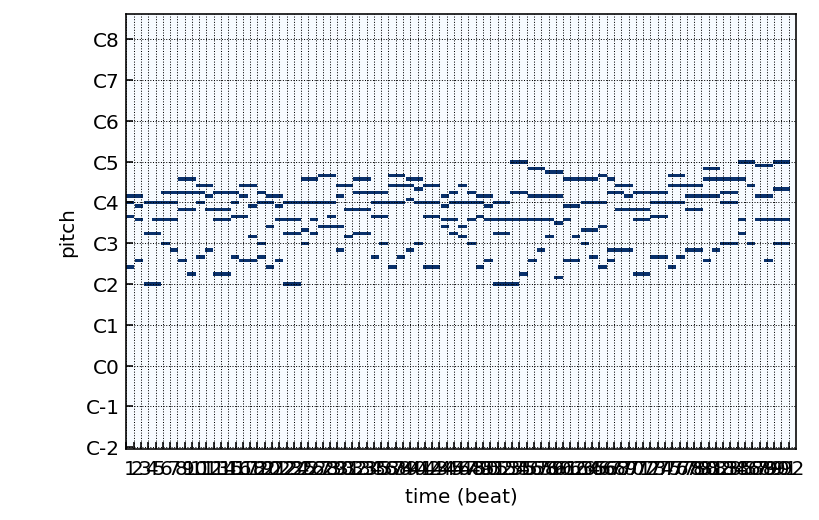

In [ ]:
multitrack = pypianoroll.read("/content/JSB Chorales/test/105.mid")

#print(multimid)
print(multitrack)
#multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

print(multitrack)

multitrack.plot()


In [ ]:


#folder_path = "train"

pieces = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]

for piece in pieces:

    folder_name = piece.split('.')[0]

    new_path = os.path.join(train_dir, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_piece_path = os.path.join(train_dir, piece)
    new_piece_path = os.path.join(new_path, piece)
    shutil.move(old_piece_path, new_piece_path)

In [ ]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)    

In [ ]:
train_data = []

dataset_root = Path("/content/JSB Chorales/")

train_dir = os.path.join(dataset_root, 'train')

# Iterate over all the songs in the ID list

for filename in os.listdir(train_dir):
    if filename.endswith(".mid") or filename.endswith(".py"):
      #print(os.path.join(train_dir, filename))

      multitrack = pypianoroll.read(os.path.join(train_dir, filename))
      # Binarize the pianorolls
      multitrack.binarize()
      # Downsample the pianorolls (shape: n_timesteps x n_pitches)
      multitrack.set_resolution(beat_resolution)
      # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
      pianoroll = (multitrack.stack() > 0)
      # Get the target pitch range only
      pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
      # Calculate the total measures
      n_total_measures = multitrack.get_max_length() // measure_resolution
      candidate = n_total_measures - n_measures
      target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
      # Randomly select a number of phrases from the multitrack pianoroll
      for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
          continue
        train_data.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(train_data)
data = np.stack(train_data)
print(f"Successfully collect {len(train_data)} samples") #from {len(id_list)} songs
print(f"Data shape : {train_data.shape}")

"""
      continue
    else:
      continue

#for directory in os.listdir(train_dir):
  # Load the multitrack as a pypianoroll.Multitrack instance
  #song_dir = train_dir / directory / 

"""